In [35]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [36]:
from summer2 import CompartmentalModel
from summer2.parameters import Parameter

**Model 1: Simple SIR**

In [37]:
def build_model():
    m = CompartmentalModel([0,100], ["S","E","I","R"],"I",ref_date=datetime(2020,6,1))
    m.set_initial_population({"S": 13781001.0, "E": 832.0 , "I": 3622.0, "R": 14178.0})
    m.add_infection_frequency_flow("infection", Parameter("contact_rate"),"S","E") 
    m.add_transition_flow("progression", 0.2,"E","I")
    m.add_transition_flow("recovery", 0.0714,"I","R") 
    m.request_output_for_flow("infection", "infection")
    m.request_output_for_flow("progressions", "progression" )
    m.request_output_for_flow("recovery", "recovery")
    return m

In [38]:
m = build_model()

In [39]:
parameters = {"contact_rate": 0.43}

In [40]:
m.run(parameters)

<Axes: >

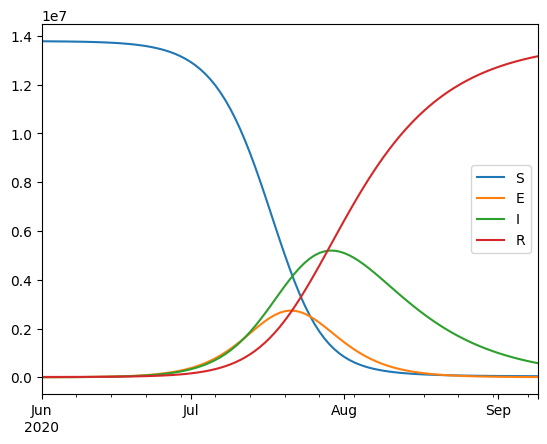

In [41]:
m.get_outputs_df().plot()

<Axes: >

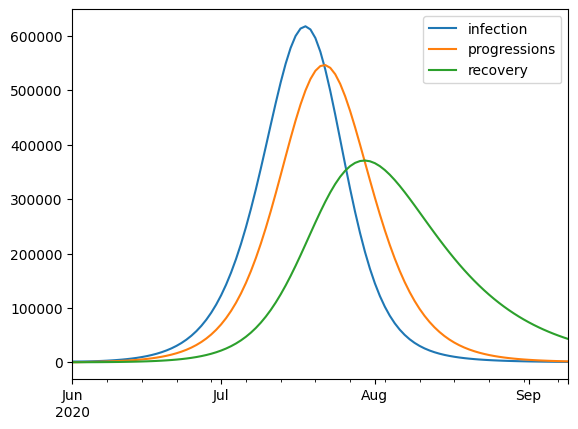

In [42]:
m.get_derived_outputs_df().plot()

In [81]:
df=pd.read_excel(io='InfectionsData_060120_093020.xlsx',index_col=0)
inf_data = df["INFECTIONS"]
active_data=df["ACTIVE CASES"]

<Axes: xlabel='DATE'>

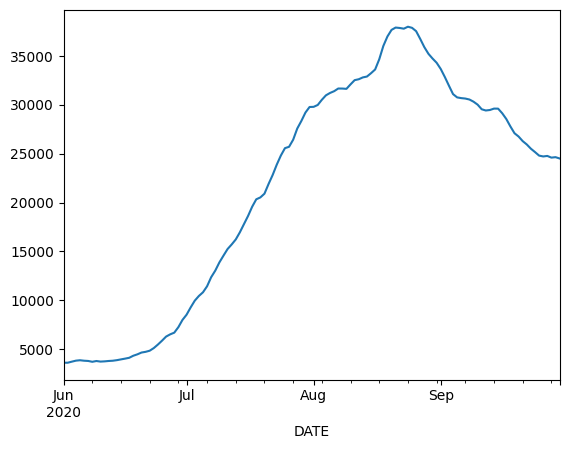

In [82]:
#inf_data.plot()
active_data.plot()

In [85]:
inf_data_cal = inf_data[:61]
active_data_cal = active_data[:61]

<Axes: xlabel='DATE'>

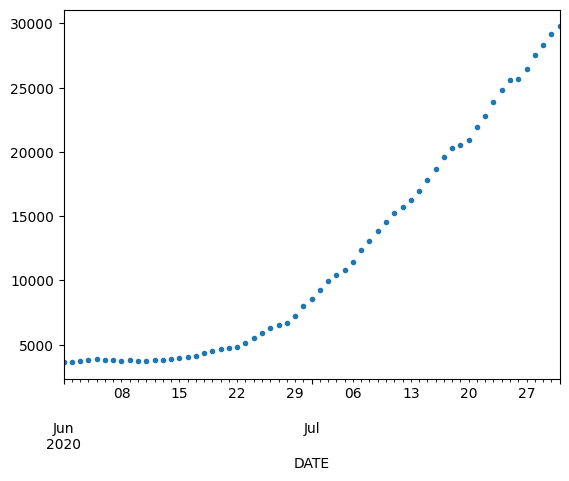

In [86]:
#inf_data_cal.plot(style='.')
active_data_cal.plot(style='.')

**Calibration**

In [47]:
# Targets represent data we are trying to fit to
from estival import targets as est

# We specify parameters using (Bayesian) priors
from estival import priors as esp

# Finally we combine these with our summer2 model in a BayesianCompartmentalModel (BCM)
from estival.model import BayesianCompartmentalModel

In [48]:
targets = [
    est.NormalTarget("infection", inf_data_cal, np.std(inf_data_cal) * 0.1),
]

In [74]:
priors = [
    esp.UniformPrior("contact_rate", (0.1,1.0)),
]

In [75]:
defp = {"contact_rate": 0.3}

In [76]:
bcm = BayesianCompartmentalModel(m, defp, priors, targets)
from estival.wrappers import pymc as epm
import pymc as pm

In [77]:
with pm.Model() as model:

    # This is all you need - a single call to use_model
    variables = epm.use_model(bcm)

    # The log-posterior value can also be output, but may incur additional overhead
    # Use jacobian=False to get the unwarped value (ie just the 'native' density of the priors
    # without transformation correction factors)
    # pm.Deterministic("logp", model.logp(jacobian=False))

    # Now call a sampler using the variables from use_model
    # In this case we use the Differential Evolution Metropolis sampler
    # See the PyMC docs for more details
    idata = pm.sample(step=[pm.DEMetropolis(variables)], draws=8000, tune=0,cores=4,chains=4)

Population sampling (4 chains)
DEMetropolis: [contact_rate]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 4 chains for 0 tune and 8_000 draw iterations (0 + 32_000 draws total) took 43 seconds.


**Visualizing Outputs**

In [78]:
import arviz as az

In [79]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
contact_rate,0.2,0.005,0.2,0.2,0.0,0.0,4839.0,5161.0,1.0


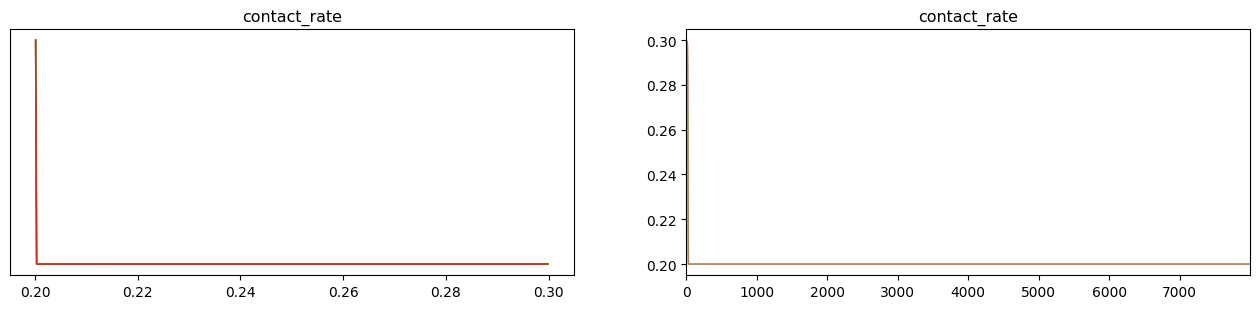

In [80]:
az.plot_trace(idata, figsize=(16,3.2*len(idata.posterior)),compact=False);#, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);

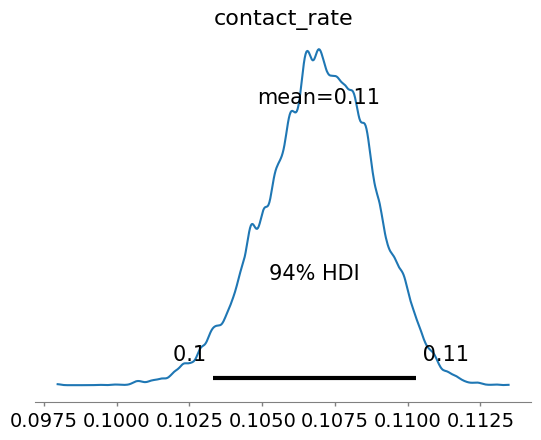

In [56]:
az.plot_posterior(idata);

**Obtaining Likelihood**

In [57]:
from estival.sampling.tools import likelihood_extras_for_idata

In [58]:
likelihood_df = likelihood_extras_for_idata(idata, bcm)

<Axes: xlabel='draw'>

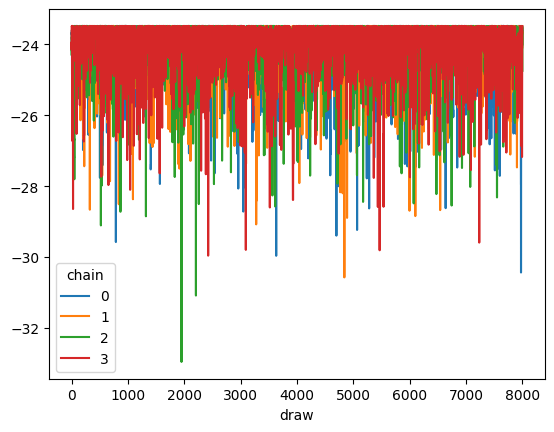

In [59]:
ldf_pivot = likelihood_df.reset_index(level="chain").pivot(columns=["chain"])

ldf_pivot["logposterior"].plot()

In [60]:
# Sort this DataFrame by logposterior to obtain the MAP index
ldf_sorted = likelihood_df.sort_values(by="logposterior",ascending=False)

# Extract the parameters from the calibration samples
map_params = idata.posterior.to_dataframe().loc[ldf_sorted.index[0]].to_dict()

map_params

{'contact_rate': 0.10713327763034064}

In [61]:
bcm.loglikelihood(**map_params), ldf_sorted.iloc[0]["loglikelihood"]

(Array(-25.13691515, dtype=float64), -25.13691514807783)

In [62]:
map_res = bcm.run(map_params)

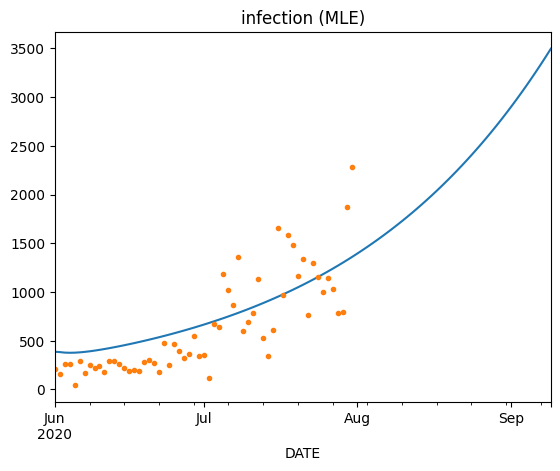

In [63]:
variable = "infection"

pd.Series(map_res.derived_outputs[variable]).plot(title = f"{variable} (MLE)")
bcm.targets[variable].data.plot(style='.');

**Compare with Actual Data for August 2020**

<Axes: title={'center': 'infection (MLE)'}, xlabel='DATE'>

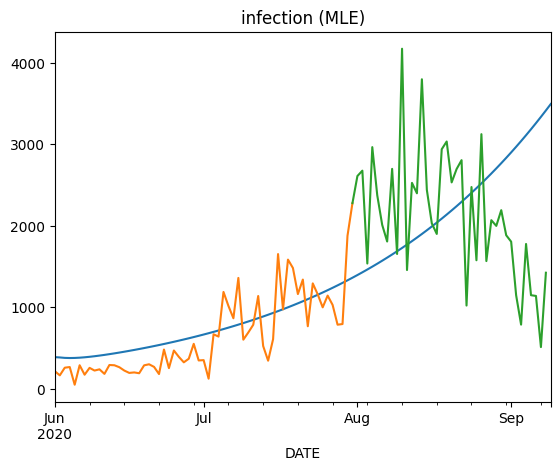

In [64]:
pd.Series(map_res.derived_outputs[variable]).plot(title = f"{variable} (MLE)")
inf_data[:61].plot()
inf_data[60:100].plot()

**Uncertainty Sampling**

In [65]:
sample_idata = az.extract(idata, num_samples = 400)
samples_df = sample_idata.to_dataframe().drop(columns=["chain","draw"])

In [66]:
from estival.utils.parallel import map_parallel

In [67]:
def run_sample(idx_sample):
    idx, params = idx_sample
    return idx, bcm.run(params)

In [68]:
sample_res = map_parallel(run_sample, samples_df.iterrows(), n_workers=4)

In [69]:
import xarray as xr

In [70]:
xres = xr.DataArray(np.stack([r.derived_outputs for idx, r in sample_res]),
                    dims=["sample","time","variable"])
xres = xres.assign_coords(sample=sample_idata.coords["sample"],
                          time=map_res.derived_outputs.index, variable=map_res.derived_outputs.columns)

In [71]:
# Set some quantiles to calculate
quantiles = (0.01,0.05,0.25,0.5,0.75,0.95,0.99)

# Generate a new DataArray containing the quantiles
xquantiles = xres.quantile(quantiles,dim=["sample"])

In [72]:
# Extract these values to a pandas DataFrame for ease of plotting

uncertainty_df = xquantiles.to_dataframe(name="value").reset_index().set_index("time").pivot(columns=("variable","quantile"))["value"]

<Axes: title={'center': 'infection'}, xlabel='DATE'>

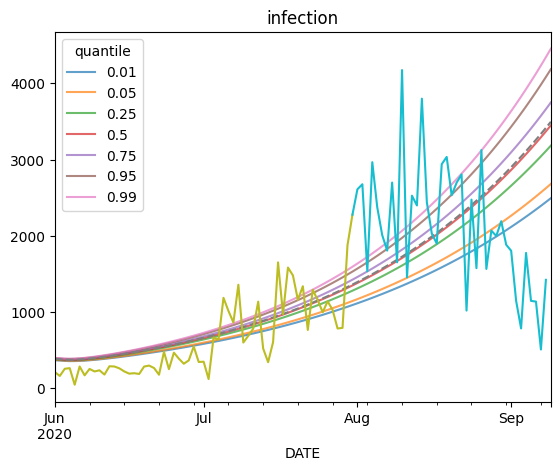

In [73]:
variable = "infection"

fig = uncertainty_df[variable].plot(title=variable,alpha=0.7)
pd.Series(map_res.derived_outputs[variable]).plot(style='--')
inf_data[:61].plot()
inf_data[60:100].plot()